In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dual(Q, v, p):
    return v.T @ Q @ v + p.T @ v

def objective(Q, v, p, A, b, t):
    if np.any(b - A @ v <= 0):
        return float("NaN")
    return t*(v.T @ Q @ v + p.T @ v) - np.sum(np.log(b - A @ v))

def barrier_gradient(A, v, b):
    return A.T @ (1. /(b - A @ v))

def barrier_hessian(A, v, b):
    return A.T @ np.diag(1/(b - A @ v)**2) @ A

def gradient(Q, v, p, A, b, t):
    return t*(2 * Q @ v + p) + barrier_gradient(A, v, b)

def hessian(Q, v, p, A, b, t):
    return 2*t*Q + barrier_hessian(A, v, b)

In [3]:
def line_search(f, grad_f, v, dv, b, A, alpha=.5, beta=.9):
    step = 1

    while f(v + step * dv) > f(v) + alpha * step * grad_f(v).T @ dv and step > 1e-6:
        step *= beta
        
        if np.any(b - A @ (v + step * dv) <= 0):
            return step

    return step

def centering_step(Q, p, A, b, t, v0, eps, max_iter=500, alpha=.5, beta=.9):
    v_seq = [v0]
    v = v0
    i = 0

    while i < max_iter:
        try:
            dv = np.linalg.inv(hessian(Q, v, p, A, b, t)) @ gradient(Q, v, p, A, b, t)
        except np.linalg.LinAlgError:
            print("Hessian is not invertible")
            print(hessian(Q, v0, p, A, b, t))
            return None
        
        step = line_search(lambda v: objective(Q, v, p, A, b, t), lambda v: gradient(Q, v, p, A, b, t), v, dv, b, A, alpha, beta)
        v = v - step * dv
        v_seq.append(v)
        lambda_squared = gradient(Q, v, p, A, b, t).T @ dv
        if lambda_squared / 2 < eps:
            break
        i += 1

    return v_seq

In [4]:
def barr_method(Q, p, A, b, v0, eps, mu, alpha=.5, beta=.9, max_iter=500):
    m = A.shape[0]
    t = 1
    v_seq = [v0]
    v = v0
    f_obj = objective(Q, v, p, A, b, t)
    f_seq = [f_obj]
    precision_criterion_seq = [m/t]
    i = 0
    while m/t >= eps:
        v_step = centering_step(Q, p, A, b, t, v, eps, max_iter=max_iter, alpha=alpha, beta=beta)
        v = v_step[-1]
        t = mu*t
        v_seq.append(v)
        f_obj = dual(Q, v, p)
        f_seq.append(f_obj)
        precision_criterion_seq.append(m/t)
        i += 1
        
    return v_seq, f_seq, precision_criterion_seq

def generate_parameters(n, d, reg=10):
    
    X = 3 * np.random.randn(n, d)
    y = 5 + 1.5 * np.random.randn(n)

    Q = np.eye(n) / 2
    p = - y

    A = np.concatenate((X.T, - X.T), axis=0)
    b = reg * np.ones(2 * d)

    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

Test of the method implemented 

In [16]:
n = 10
d = 5
reg = 10
X, y, Q, p, A, b, v0 = generate_parameters(n, d, reg)

epsilon = 1e-9
alpha = 0.5
beta = 0.9
max_iter = 500

mu_list = [2, 15, 50, 100, 500, 1000]
result = []
for mu in mu_list:
    v_seq, f_seq, precision_criterion_seq = barr_method(Q, y, A, b, v0, epsilon, mu, alpha, beta)
    result.append([v_seq, f_seq, precision_criterion_seq])
f_opt = np.infty
for i in range(len(result)):
    f_opt = min(f_opt, result[i][1][-1])

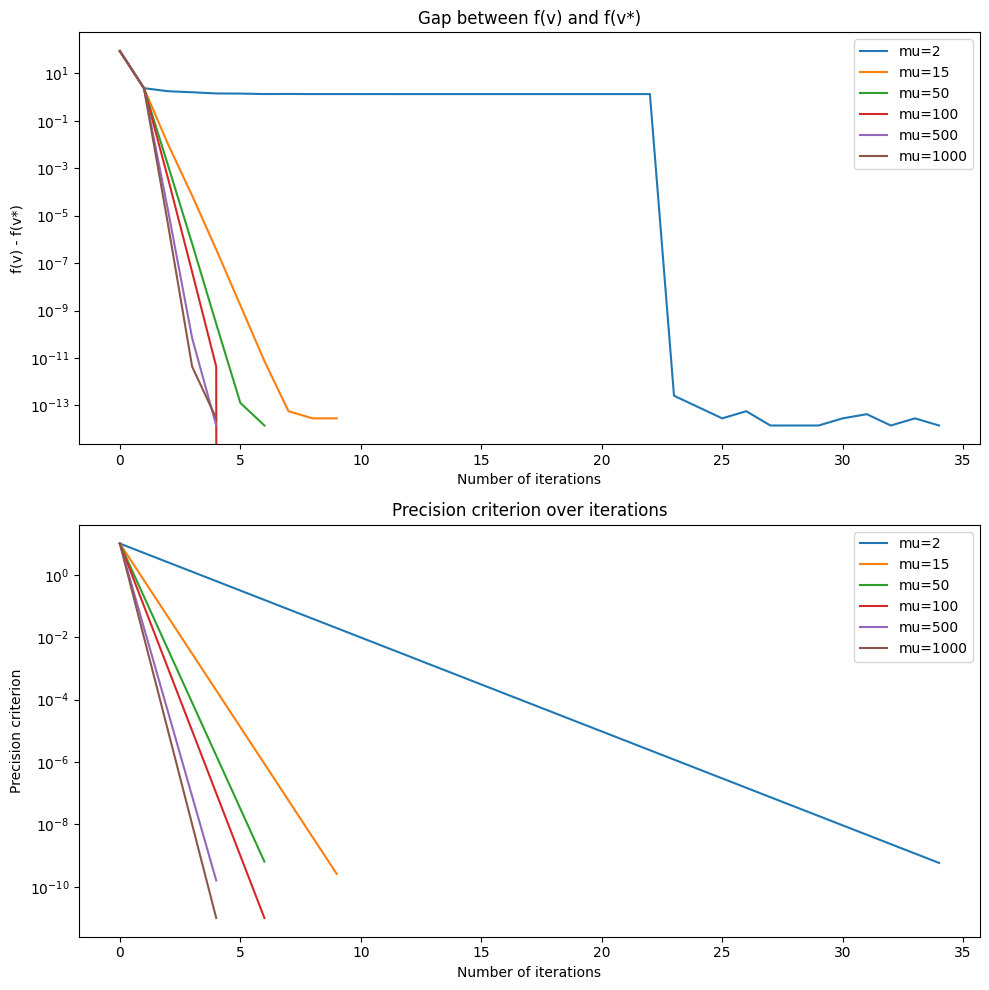

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot f_seq - f_opt
for i, res in enumerate(result):
    ax1.semilogy(res[1] - f_opt, label=f"mu={mu_list[i]}")
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("f(v) - f(v*)")
ax1.set_title("Gap between f(v) and f(v*)")
ax1.legend()

# Plot precision criterion
for i, res in enumerate(result):
    ax2.semilogy(res[2], label=f"mu={mu_list[i]}")
ax2.set_xlabel("Number of iterations")
ax2.set_ylabel("Precision criterion")
ax2.set_title("Precision criterion over iterations")
ax2.legend()

plt.tight_layout()
plt.show()